#### Introduction:

The dataset contains 67,986 reviews from Amazon about cell phones from 2003 until 2019 for the 10 cell phone categories. Each review can be associated with an item and brand name and comes with a rating ranging from 1 to 5. This makes the dataset a perfect sample for text analytics and sentiment classification.

#### Importing the libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
import pickle

import nltk
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer

from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from mlxtend.plotting import plot_confusion_matrix


# To save the final model on disk
from sklearn.externals import joblib

#### Reading the CSV file data.

In [418]:
df_reviews = pd.read_csv("363619_861634_bundle_archive/20191226-reviews.csv")
df_item = pd.read_csv("363619_861634_bundle_archive/20191226-items.csv")

#### Displaying the first few rows from both the dataframes

In [419]:
df_reviews.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [420]:
df_item.head()

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0


#### Shape of the dataframe

In [421]:
df_reviews.shape

(67986, 8)

In [422]:
df_item.shape

(720, 10)

#### Mobile phone of all categories.

In [423]:
print("Total number of mobile phone brands are : ", df_item['brand'].nunique())
print(df_item['brand'].unique())

Total number of mobile phone brands are :  10
[nan 'Motorola' 'Nokia' 'Samsung' 'HUAWEI' 'Sony' 'Apple' 'Google' 'ASUS'
 'OnePlus' 'Xiaomi']


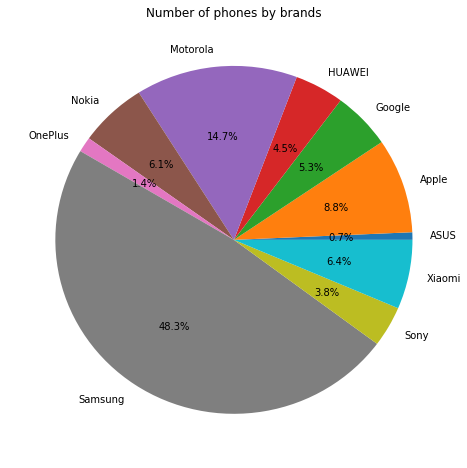

In [424]:
label = ['ASUS', 'Apple', 'Google', 'HUAWEI', 'Motorola', 'Nokia', 'OnePlus', 'Samsung', 'Sony', 'Xiaomi']
plt.figure(figsize = (8, 8))
plt.title("Number of phones by brands")
item = df_item.groupby("brand").count()['totalReviews']
plt.pie(item, labels = label, autopct = '%1.1f%%')
plt.show()

As we can see from above pie chart there are more number of Samsung mobile phone (around 50%) reviews as compared to other mobile phones.

Now let's look at the average ratings for each of the brand.

In [425]:
df_item.groupby("brand").mean()["rating"].sort_values()

brand
Nokia       3.386364
OnePlus     3.580000
Samsung     3.632659
Motorola    3.643810
Google      3.771053
Apple       3.782540
Sony        3.788889
ASUS        3.860000
HUAWEI      4.021875
Xiaomi      4.415217
Name: rating, dtype: float64

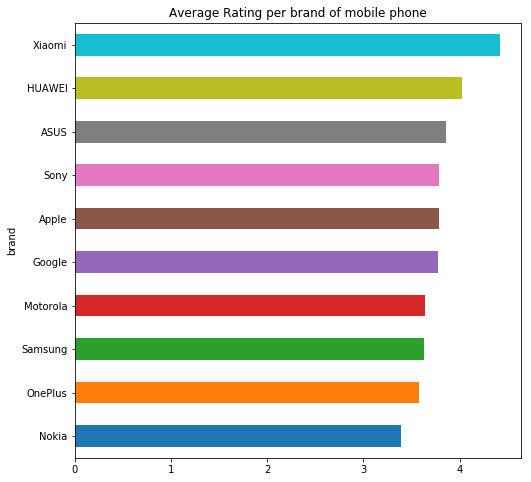

In [426]:
rate = df_item.groupby("brand").mean()["rating"].sort_values()

ax = rate.plot(kind="barh", figsize=(8,8), title="Average Rating per brand of mobile phone")
plt.show()

The Xiaomi mobile phone ratings are more as compared to other mobile phones.

Now we will merge the two dataframes.

In [427]:
df = pd.merge(df_reviews, df_item, how="left", left_on="asin", right_on="asin")

In [428]:
df.shape

(67986, 17)

In [429]:
df.head()

,asin,name,rating_x,date,verified,title_x,body,helpfulVotes,brand,title_y,url,image,rating_y,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


In [430]:
df.columns

Index(['asin', 'name', 'rating_x', 'date', 'verified', 'title_x', 'body',
       'helpfulVotes', 'brand', 'title_y', 'url', 'image', 'rating_y',
       'reviewUrl', 'totalReviews', 'price', 'originalPrice'],
      dtype='object')

In [431]:
#Renaming the column names
df.rename(columns={"rating_x": "rating", "title_x": "title", "title_y": "item_title", "rating_y": "overall_rating"}, inplace=True)
df.head()

,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


Now we will convert the date into appropriate format so that we can visualize it using some graphs.

In [432]:
df["Date"] = df["date"].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))

In [433]:
df['Month'] = pd.DatetimeIndex(df['date']).month
df['Year'] = pd.DatetimeIndex(df['date']).year

In [434]:
print(df['Year'].nunique())
print(df['Year'].sort_values().unique())

17
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019]


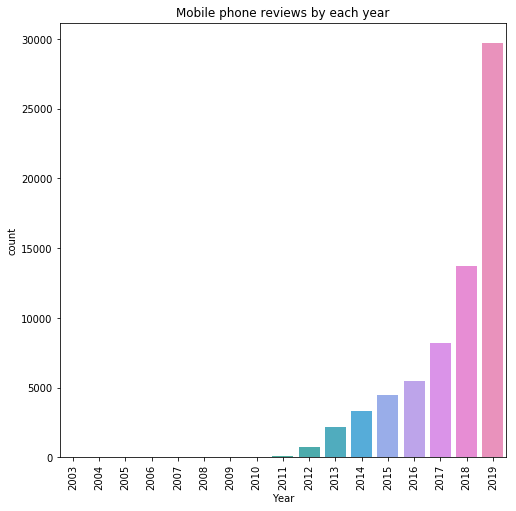

In [435]:
plt.figure(figsize = (8, 8))
plt.title("Mobile phone reviews by each year")
plt.xticks(rotation = 90)
plt.xlabel("Year")
plt.ylabel("Number of reviews")
sns.countplot(data = df, x = df['Year'])

As we move from 2003 to 2019 the number of reviews has been increased. So we can clearly see the peoples have started using mobile phones as the year passes.

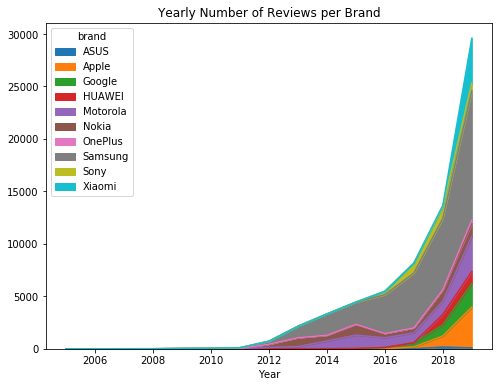

In [436]:
# Plotting reviews over the years
ax = pd.pivot_table(df, 
                    index="Year", 
                    columns="brand", 
                    values="asin", 
                    aggfunc="count", 
                    fill_value=0).plot.area(title="Yearly Number of Reviews per Brand", figsize=(8, 6))

The Xiaomi has the highest average ratings. Samsung and apple has highest number of ratings.

#### Text Cleaning
Here we will doing text cleaning like lower casing, puncation removal, and so on.

In [437]:
def clean_text(text):
    
    ## Defining keywords to remove
    #keywords = df["brand"].astype("str").apply(lambda x: x.lower()).unique().tolist()
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Removing keywords
    #text = [word for word in text if word not in keywords]
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r'http\S+', '', text)  # Removing the URL's from the text
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"\{", " ", text)
    text = re.sub(r"\}", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"e - mail", "email", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [438]:
df["body"] = df["body"].astype("str")
df['Cleaned_body'] = df['body'].map(lambda x: clean_text(x))

Let's check some reviews before and after cleaning.

In [439]:
print(df['body'][10])
df['Cleaned_body'][10]

I've had this phone for over a year and I really like it. Having never been partial to flip phones, I can appreciate this Nokia's features. The color screen is very nice and all of the features are easy to use. The keylock is a simple two-button sequence though I do wish it had a timer for the keylock like my old phone. It has a lot of useful features, like a calculator, organizer, stopwatch and alarm, but the three games it has are too lame to play. The customizable features are nice, but lacking in variety. This isn't the ideal phone for a guy. You're few options are pretty girly. The ringtones also lack something to be desired, but there are a few decent ones. The battery life is pretty good, nothing special, but definitely not bad. It gets me through the average day without problems and sometimes lasts for several days. My parents, sisters, and husband all got fancy Samsung flip phones with cameras and all the toys, and I must say mine works better. The battery lasts MUCH longer an

'i have phone year realli like it never partial flip phone appreci nokia featur color screen nice featur easi use keylock simpl two button sequenc though wish timer keylock like old phone lot use featur like calcul organ stopwatch alarm three game lame play customiz featur nice lack varieti ideal phone guy option pretti gir rington also lack someth desir decent one batteri life pretti good noth special definit bad get averag day without problem sometim last sever day parent sister husband got fanci samsung flip phone camera toy must say mine work better batteri last much longer recpet much better downsid cute phone case made weak plastic crack month also think get differ case it do not take off keep slip off never attach firm again neither new case bought i have read review too this last time drop back piec pop batteri flew out phone issu drat overal great phone content simpler thing life realli use camera thier phone anyway reccommend buy protect case leav drop delic thing'

In [440]:
print(df['body'][50])
df['Cleaned_body'][50]

This is not a "boost" phone and will not work as a GPS with Boost. Had to send it back. A huge pain for something that is $24. This is a rip-off.


'boost phone work gps boost send back huge pain someth 24 rip off'

In [441]:
print(df['body'][1000])
df['Cleaned_body'][1000]

It is durable but I am on my 4th phone so I am not sure how rugged it is. I still like it.


'durabl 4th phone sure rug is still like it'

The cleaning of the text is now done. Now we will convert the review ratings into positive and negative based on the reviews score.

In [442]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

## Pandas Series have a map function which apply function object to all the elements
df['Score'] = df['rating'].map(partition)

In [443]:
df['Score'].unique()

array(['positive', 'negative'], dtype=object)

#### Word Cloud

We have separatted the reviews according to their ratings – positive reviews (4 or 5 star) and negative reviews (1 or 2 star). In both type of reviews there are certain common words like “work”, “battery” and “screen”. The most frequently used words in positive reviews are: “great”, “good”, “camera”, “price”, “excellent”, etc. In case of negative reviews words such as “return”, “back”, “problem”, “charge” are prevalent.

In [28]:
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict

In [29]:
# Define a function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [30]:
# Define a function to plot top10 positive words and top10 negative words in a grouped bar plot (from dictionaries)
def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transform positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    # Transform negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

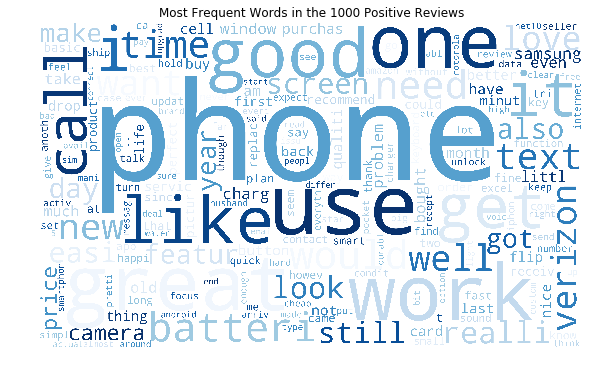

In [87]:
# Plotting wordcloud for 1000 positive reviews
pos_words = " ".join(df[df["Score"]=='positive']["Cleaned_body"][:1000])
#print(pos_words)
pos_words_freq = word_freq_dict(pos_words)
#print(pos_words_freq)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(pos_words_freq, "Most Frequent Words in the 1000 Positive Reviews")

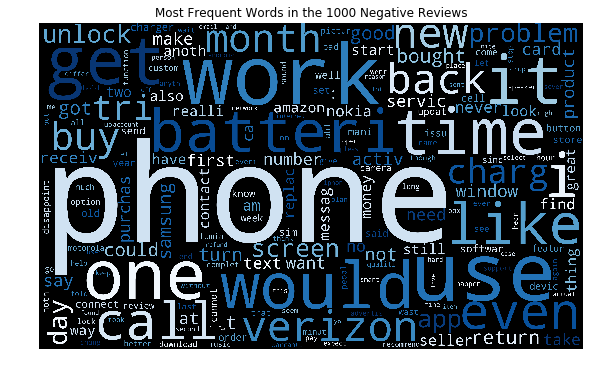

In [88]:
# Plotting wordcloud for 1000 negative reviews
neg_words = " ".join(df[df["Score"]=='negative']["Cleaned_body"][:1000])
#print(pos_words)
neg_words_freq = word_freq_dict(neg_words)
#print(pos_words_freq)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="black")
wordcloud_from_frequency(pos_words_freq, "Most Frequent Words in the 1000 Negative Reviews")

Now we will drop the all the unnecessary columns and will keep only review body and its polarity i.e. positive or negative.

In [444]:
df.drop(['asin', 'name', 'rating', 'date', 'verified', 'title', 'body',
       'helpfulVotes', 'brand', 'item_title', 'url', 'image', 'overall_rating',
       'reviewUrl', 'totalReviews', 'price', 'originalPrice', 'Date', 'Month',
       'Year'], axis = 1, inplace = True)

In [445]:
df.columns

Index(['Cleaned_body', 'Score'], dtype='object')

In [446]:
df.to_csv("Cleaned_data.csv", index = True)

Dropping duplicate rows if any.

In [414]:
df = pd.read_csv("Cleaned_data.csv")

In [447]:
df.shape

(67986, 2)

In [448]:
df.drop_duplicates(inplace = True)

In [449]:
df.shape

(57107, 2)

So there were around 10K duplicate reviews that we have dropped.

Finding if have null value

In [450]:
df.isnull().sum()

Cleaned_body    0
Score           0
dtype: int64

In [451]:
df['Score'].value_counts()

positive    41657
negative    15450
Name: Score, dtype: int64

So our dataset is not balanced. Therefore we take now shuffle the dataframe and take 10000 reviews from each class.

In [452]:
df = df.sample(frac=1)

In [453]:
df.head()

,Cleaned_body,Score
44882,bit hesit order pixel replac pixel xl absolut ...,positive
4365,love window phone,positive
53325,warn : list unlock still receiv verizon devic ...,negative
21025,old appl 4 0 phone decid replac samsung galaxi...,negative
64478,display note 10 phenomen star show watch lot v...,positive


In [454]:
df_pos = df[df['Score'] == 'positive'][:2000]
df_neg = df[df['Score'] == 'negative'][:2000]

In [455]:
print(df_pos.shape)
df_neg.shape

(2000, 2)


(2000, 2)

Concating the 2 dataframes.

In [456]:
df = pd.concat([df_pos, df_neg], axis = 0)

In [457]:
df = df.sample(frac=1)
print(df.shape)

(4000, 2)


In [458]:
df.head()

,Cleaned_body,Score
18840,amaz phone bought mother law love it latest gr...,positive
66196,first smart phone great price 180 batteri last...,positive
13736,great phone also cheap,positive
22487,good : stun display impress 5 5 quad hd screen...,positive
55075,vendedor especifica que celular vien con mano ...,positive


In [459]:
X1 = df['Cleaned_body']
X2 = df['Cleaned_body']
y = df['Score']

#### TF-IDF model

In [460]:
tf_idf_vec=TfidfVectorizer(analyzer='word', 
    sublinear_tf=True,
    strip_accents='unicode',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1))
tf_idf=tf_idf_vec.fit(X1)

In [461]:
tf_idf1=TfidfVectorizer(analyzer='word', 
    sublinear_tf=True,
    strip_accents='unicode',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1))
tf_idf_model = tf_idf1.fit_transform(X2)

In [462]:
with open("TF_IDF_model.pkl","wb") as tf_idf_model_disk:
    pickle.dump(tf_idf,tf_idf_model_disk)

In [465]:
X =pd.DataFrame(list(tf_idf_model.toarray()))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,7063,7064,7065,7066,7067,7068,7069,7070,7071,7072
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [466]:
def score(sc):
    if sc=='positive':
        return 1
    else:
        return 0

In [467]:
y = y.map(score)

#### Column Standardization

In [468]:
a=StandardScaler()
x=a.fit_transform(X)

In [469]:
x[:5,:]

array([[-0.0767896 , -0.05918281, -0.04184421, ..., -0.06032298,
        -0.03490108, -0.02746819],
       [-0.0767896 , -0.05918281, -0.04184421, ..., -0.06032298,
        -0.03490108, -0.02746819],
       [-0.0767896 , -0.05918281, -0.04184421, ..., -0.06032298,
        -0.03490108, -0.02746819],
       [-0.0767896 , -0.05918281, -0.04184421, ..., -0.06032298,
        -0.03490108, -0.02746819],
       [-0.0767896 , -0.05918281, -0.04184421, ..., -0.06032298,
        -0.03490108, -0.02746819]])

In [470]:
with open("standardization.pkl","wb") as std:
    pickle.dump(a,std)

#### Splitting data into training and testing

In [471]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [472]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 7073)
(800, 7073)
(3200,)
(800,)


#### 1. Logistic Regression

In [473]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [474]:
print(log_reg.score(X_test, y_test))

0.73125


In [475]:
y_pred = log_reg.predict(X_test)

In [476]:
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
acc

73.125

In [477]:
confusion_matrix(y_test,y_pred).T

array([[293, 108],
       [107, 292]], dtype=int64)

([<matplotlib.axis.YTick at 0x2b182c9bcc0>,
 <a list of 2 Text yticklabel objects>)

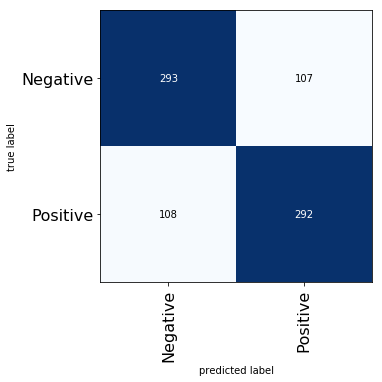

In [478]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, figsize = (10, 5 ))
plt.xticks(range(2), ['Negative', 'Positive'], fontsize=16, rotation = 90)
plt.yticks(range(2), ['Negative', 'Positive'], fontsize=16)

#### 2. KNN

In [479]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [480]:
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
acc

59.875

In [481]:
confusion_matrix(y_test,y_pred).T

array([[119,  40],
       [281, 360]], dtype=int64)

([<matplotlib.axis.YTick at 0x2b18122fb38>,
 <a list of 2 Text yticklabel objects>)

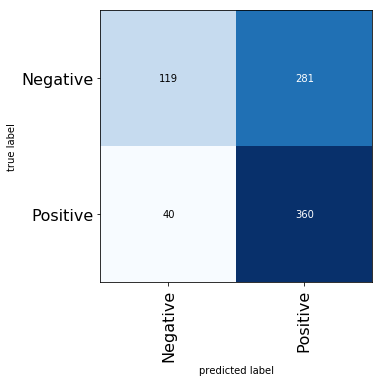

In [482]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, figsize = (10, 5 ))
plt.xticks(range(2), ['Negative', 'Positive'], fontsize=16, rotation = 90)
plt.yticks(range(2), ['Negative', 'Positive'], fontsize=16)

#### 3. Gradient Boosting

In [483]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [484]:
y_pred = gb.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
acc

80.0

In [485]:
confusion_matrix(y_test,y_pred).T

array([[346, 106],
       [ 54, 294]], dtype=int64)

([<matplotlib.axis.YTick at 0x2b1815e4c18>,
 <a list of 2 Text yticklabel objects>)

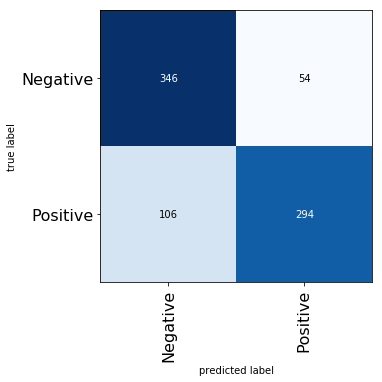

In [486]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, figsize = (10, 5 ))
plt.xticks(range(2), ['Negative', 'Positive'], fontsize=16, rotation = 90)
plt.yticks(range(2), ['Negative', 'Positive'], fontsize=16)

#### 4. Random Forest

In [487]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [488]:
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
acc

78.375

In [489]:
confusion_matrix(y_test,y_pred).T

array([[321,  94],
       [ 79, 306]], dtype=int64)

([<matplotlib.axis.YTick at 0x2b1817d0c50>,
 <a list of 2 Text yticklabel objects>)

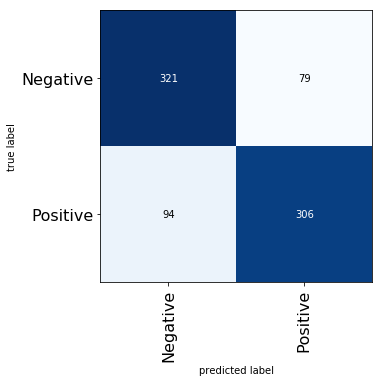

In [490]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, figsize = (10, 5 ))
plt.xticks(range(2), ['Negative', 'Positive'], fontsize=16, rotation = 90)
plt.yticks(range(2), ['Negative', 'Positive'], fontsize=16)

Of the all model performed above the gradient boosting has performed well. So we can save it on the disk for future use.

In [491]:
joblib.dump(gb, 'Model.pkl') 

['Model.pkl']

#### Model Testing

In [593]:
review = "I hate this phone very much. Very bad. Never buy it"

In [594]:
clean_review = clean_text(review)

In [595]:
clean_review

'hate phone much bad never buy'

In [596]:
model = joblib.load('Model.pkl')

std = open('standardization.pkl', 'rb')
stnd = pickle.load(std) 
std.close()


tf = open('TF_IDF_model.pkl', 'rb')
vec = pickle.load(tf) 
tf.close()

In [597]:
vector = vec.transform([clean_review])

In [598]:
vector = stnd.transform(vector.toarray())

In [599]:
vector[:,:5191].shape

(1, 5191)

In [600]:
model_pred.predict(vector[:,:5191])

array([0], dtype=int64)

In [601]:
review1 = "Very useful phone. I love it."

In [602]:
clean_review1 = clean_text(review1)
clean_review1

'use phone love it'

In [603]:
vector1 = vec.transform([clean_review1])

In [604]:
vector1 = stnd.transform(vector1.toarray())

In [605]:
model_pred.predict(vector1[:, :5191])

array([1], dtype=int64)

In [608]:
review2 = "The phone has very good battery."
clean_review2 = clean_text(review2)
print(clean_review2)

vector2 = vec.transform([clean_review2])
vector2 = stnd.transform(vector2.toarray())
model_pred.predict(vector2[:, :5191])

phone good batteri


array([1], dtype=int64)

In [628]:
review3 = "This is not a boost phone and will not work as a GPS with Boost."
clean_review3 = clean_text(review3)
print(clean_review3)

vector3 = vec.transform([clean_review3])
vector3 = stnd.transform(vector3.toarray())
model_pred.predict(vector3[:, :5191])

boost phone work gps boost


array([0], dtype=int64)